## Vertical scaling of RDark

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

In [3]:
print(pftnames[0:6])

['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree', 'needleleaf_colddecid_extratrop_tree', 'broadleaf_evergreen_extratrop_tree', 'broadleaf_hydrodecid_tropical_tree', 'broadleaf_colddecid_extratrop_tree']


###  Load the fates  runs

In [4]:
nens = 8
fates_runs = []

for i in range(1,9):
    print(i)
    #fates_tmp = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/feb24/fbnc_f45_mr_vert_{0}.E74c582a640-Feff4c934.2024-03-19/run/fbnc_f45_mr_vert_{0}.E74c582a640-Feff4c934.2024-03-19.2110s.nc'.format(i)
    fates_tmp = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/feb24/fbnc_f45_mr_vert_{0}.E74c582a640-Feff4c934.2024-03-19/run/fbnc_f45_mr_vert_{0}.E74c582a640-Feff4c934.2024-03-19.2190s.nc'.format(i)
    fates_runs.append(xr.open_dataset(fates_tmp, decode_times=False))
    

1
2
3
4
5
6
7
8


In [5]:
time = fates_runs[0].variables['time'] / 365.
cohort_size_bins = fates_runs[0].variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

### Respiration

#### Understory maintanance respiration

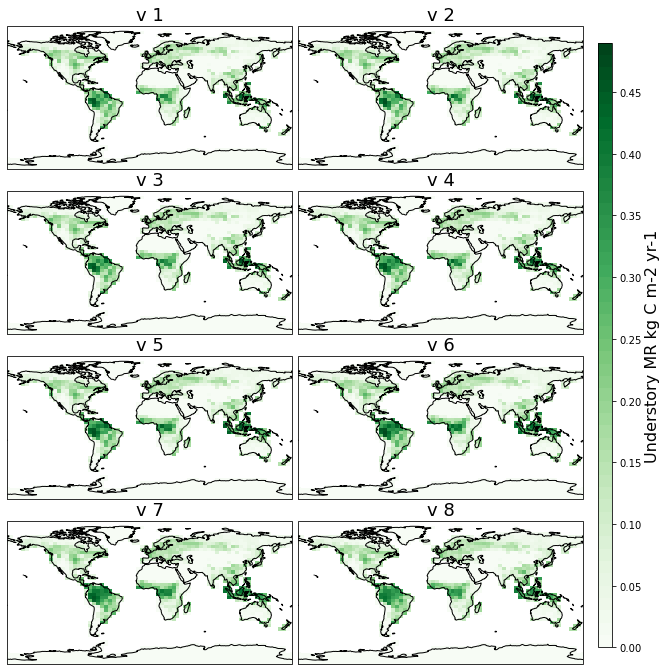

In [6]:
mus = []

clevs=np.arange(0,0.5,0.01)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    mr_u = fates_runs[i].FATES_MAINTAR_USTORY_SZ.sum(dim='fates_levscls').mean(dim=['time']) * fates_runs[i].FATES_FRACTION.mean(dim='time')
    mr_u = mr_u * 86400 * 365
    cs= mr_u.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory MR kg C m-2 yr-1', fontsize=16)

### Trimming

#### Total trimming

0.45505857
0.45948455
0.46467263
0.4713506
0.4734253
0.4834578
0.4990831
0.50635904


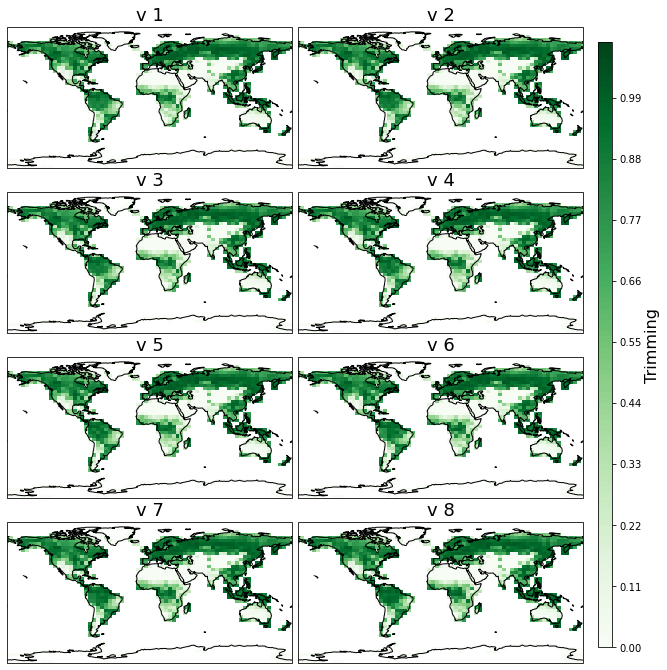

In [7]:
mus = []

clevs=np.arange(0,1.1,0.01)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    trimming = fates_runs[i].FATES_TRIMMING.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    
    # mean veg c in tropical grid cells
    trop_trimming = trimming.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    print(trop_trimming.values)
    mus.append(trop_trimming.values)
    
    cs= trimming.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Trimming', fontsize=16)

#### Difference in trimming

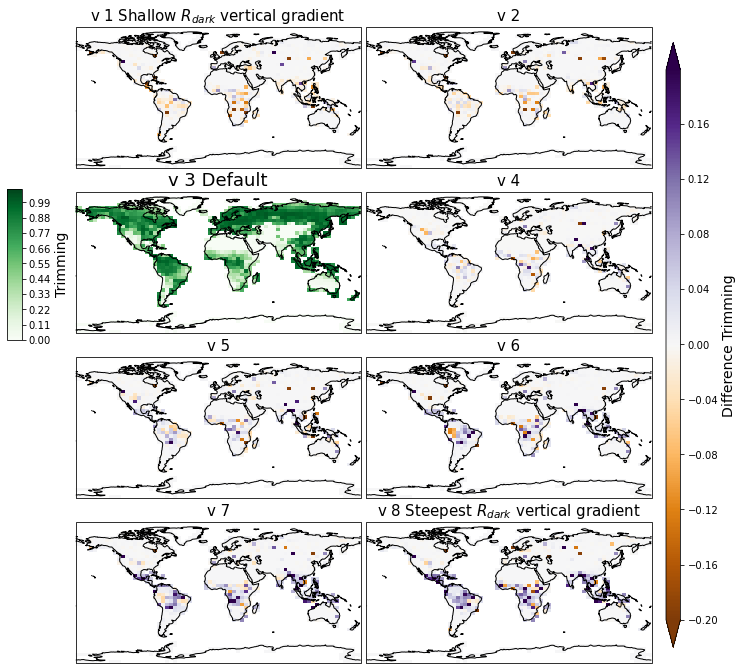

In [8]:
clevs=np.arange(-0.2,0.2,0.001)

clevs_def=np.arange(0,1.1,0.01)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

trim_def = fates_runs[2].FATES_TRIMMING.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time')

axs = axs.flatten()
for i in range(0,nens):
    trim = fates_runs[i].FATES_TRIMMING.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    trim_diff = trim - trim_def
    cs= trim_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=15)
    
    if i == 2: 
        ds= trim_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
        
   
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference Trimming', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label('Trimming', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_trimming_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_trimming_diff.pdf', 
            bbox_inches='tight', facecolor='white')

#### Total Veg C - all pfts

5.077622
5.122762
5.2454667
5.3681827
5.5687428
5.8767233
6.2137175
6.554021


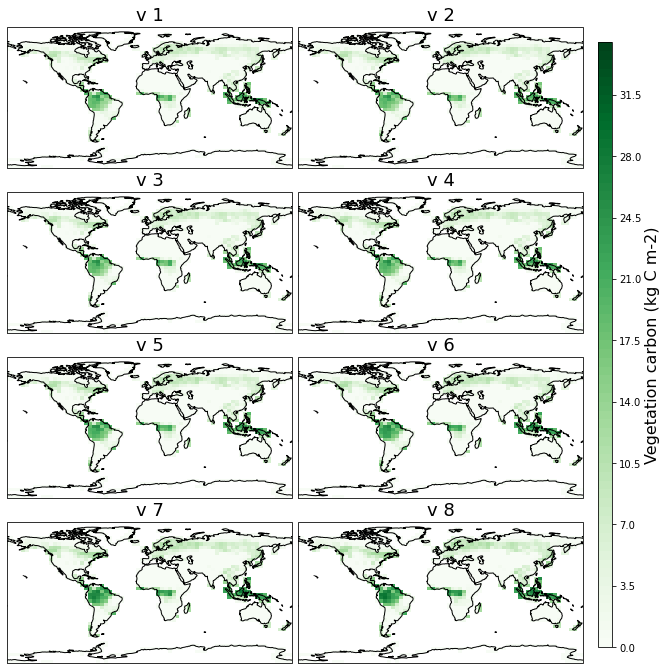

In [9]:
mus = []

clevs=np.arange(0,35,0.5)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    vegc = fates_runs[i].FATES_VEGC.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    
    # mean veg c in tropical grid cells
    trop_vegc = vegc.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    print(trop_vegc.values)
    mus.append(trop_vegc.values)
    
    cs= vegc.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Vegetation carbon (kg C m-2)', fontsize=16)

In [10]:
incr = (mus[2] - mus[7])/mus[2] * 100
print(incr)

-24.946382641792297


#### Difference in veg C - all PFTs

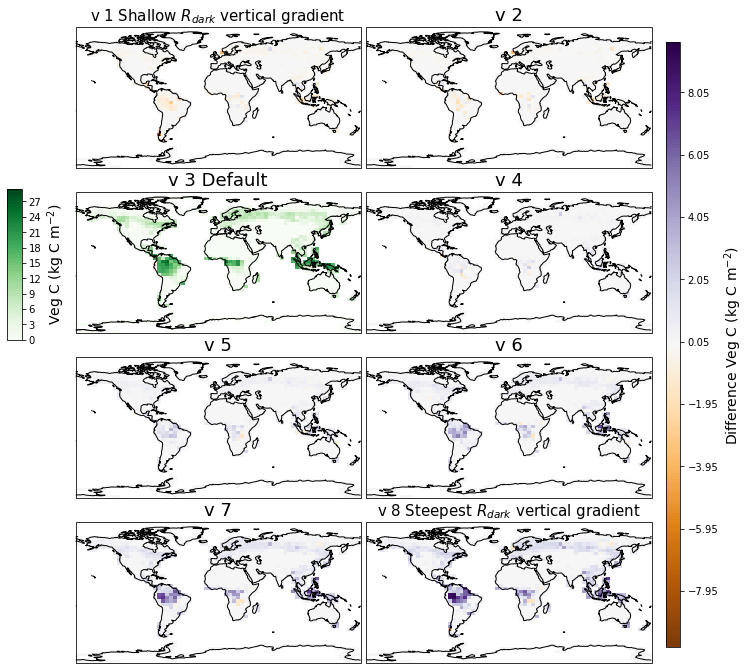

In [11]:
clevs=np.arange(-9.75,9.75,0.1)

clevs_def=np.arange(0,30,0.5)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

vegc_def = fates_runs[2].FATES_VEGC.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time')


axs = axs.flatten()
for i in range(0,nens):
    vegc = fates_runs[i].FATES_VEGC.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    vegc_diff = vegc - vegc_def
    cs= vegc_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= vegc_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
   
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference Veg C (kg C m$^{-2}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Veg C (kg C m$^{-2}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_vegc_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_vegc_diff.pdf', 
            bbox_inches='tight', facecolor='white')

### Is this from more understory plants or trees reaching larger sizes?

#### Number of plants in the  understory - only tree PFTs

0.18821561
0.19601725
0.2140267
0.23572958
0.22810633
0.2085815
0.11386658
0.056424867


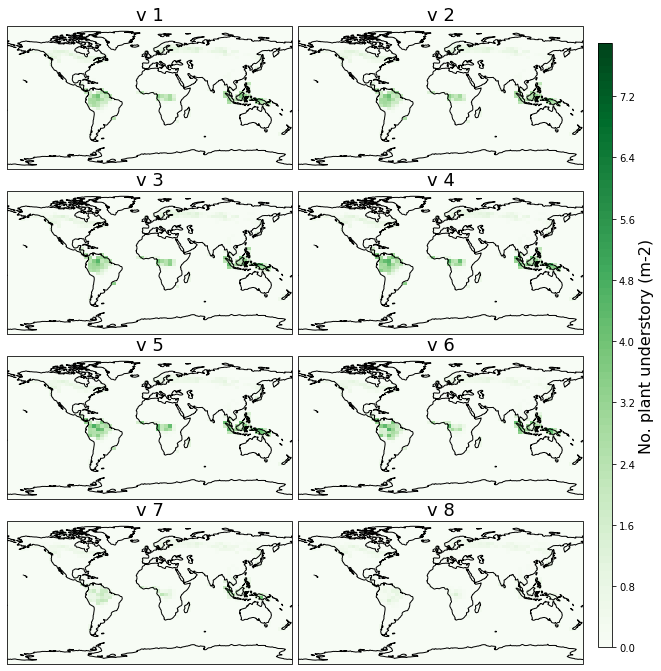

In [12]:
mus = []

clevs=np.arange(0,8,0.1)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    nplant_ustory_v1 = nplant_ustory_v1.mean(dim=['time'])
    
    trop_nplant = nplant_ustory_v1.isel(lat=slice(-30,30)).mean(dim=['lat','lon'], skipna=True)
    print(trop_nplant.values)
    mus.append(trop_nplant.values)
    
    cs= nplant_ustory_v1.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('No. plant understory (m-2)', fontsize=16)

#### Difference in number of understory plants - only tree PFTs

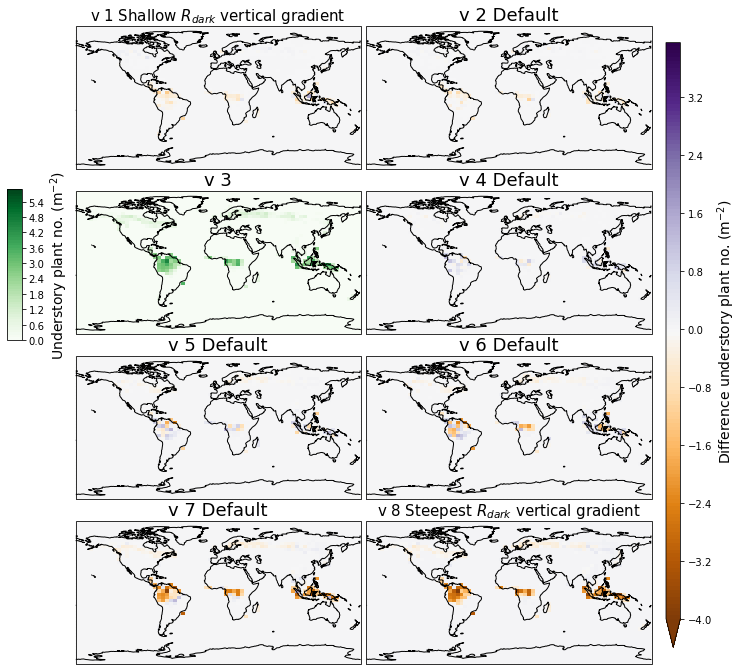

In [13]:
clevs=np.arange(-4.0,4.0,0.05)

clevs_def=np.arange(0,6,0.1)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 14))

nplant_ustory_def = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_NPLANT_USTORY_SZPF, fates_runs[2]).isel(fates_levpft=slice(0,6)) 
nplant_ustory_def = nplant_ustory_def.sum(dim=['fates_levscls','fates_levpft'])                                                                      
nplant_ustory_def = nplant_ustory_def.mean(dim=['time'])


axs = axs.flatten()
for i in range(0,nens):
    
    nplant_ustory = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory = nplant_ustory.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    nplant_ustory = nplant_ustory.mean(dim=['time'])
   
    nplant_ustory_diff = nplant_ustory - nplant_ustory_def
    cs= nplant_ustory_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= nplant_ustory_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
        
   
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference understory plant no. (m$^{-2}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Understory plant no. (m$^{-2}$)', fontsize=14)

#### Crown area in the understory (note all PFTs)

0.09975473
0.10191571
0.105664544
0.1110137
0.11464187
0.11962754
0.122771256
0.12424476


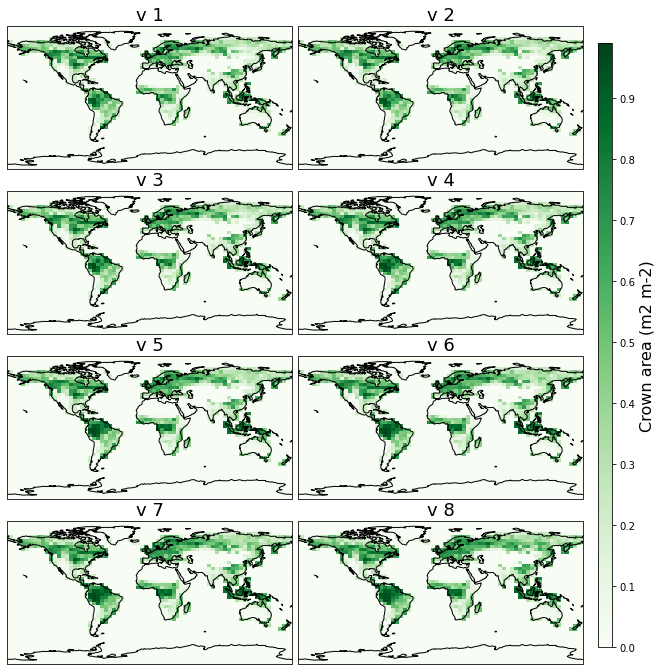

In [14]:
mus = []

clevs=np.arange(0,1,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    ca_ustory_v1 = fates_runs[i].FATES_CROWNAREA_USTORY_SZ
    ca_ustory_v1 = ca_ustory_v1.sum(dim=['fates_levscls'])                                                                      
    ca_ustory_v1 = ca_ustory_v1.mean(dim=['time'])
    
    trop_ca = ca_ustory_v1.isel(lat=slice(-30,30)).mean(dim=['lat','lon'], skipna=True)
    print(trop_ca.values)
    mus.append(trop_ca.values)
    
    cs= ca_ustory_v1.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Crown area (m2 m-2)', fontsize=16)

#### Difference in crown area - all pfts

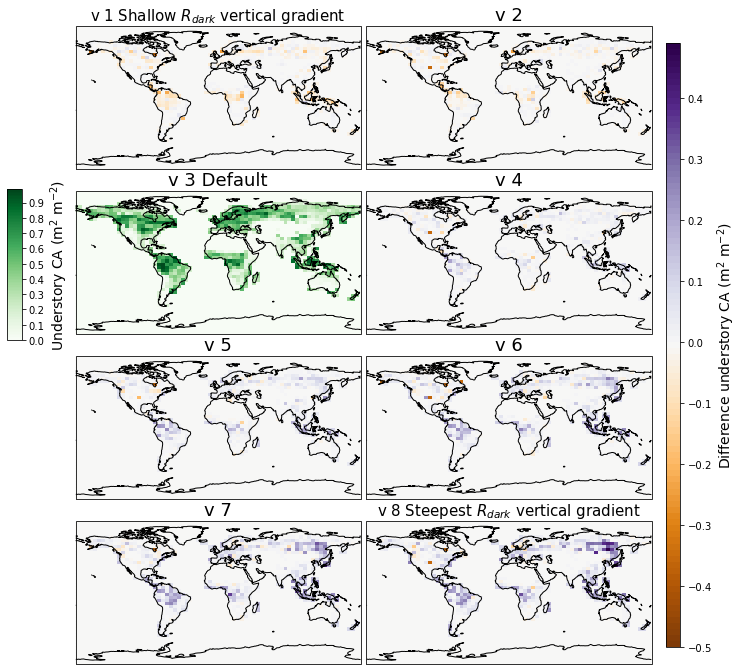

In [49]:
clevs=np.arange(-0.5,0.5,0.01)

clevs_def=np.arange(0,1,0.01)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

ca_ustory_def = fates_runs[2].FATES_CROWNAREA_USTORY_SZ
ca_ustory_def = ca_ustory_def.sum(dim=['fates_levscls'])                                                                      
ca_ustory_def = ca_ustory_def.mean(dim=['time'])


axs = axs.flatten()
for i in range(0,nens):
    ca_ustory = fates_runs[i].FATES_CROWNAREA_USTORY_SZ
    ca_ustory = ca_ustory.sum(dim=['fates_levscls'])                                                                      
    ca_ustory = ca_ustory.mean(dim=['time'])
    ca_diff = ca_ustory - ca_ustory_def
    cs= ca_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= ca_ustory_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
   
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference understory CA (m$^{2}$ m$^{-2}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Understory CA (m$^{2}$ m$^{-2}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_CA_ustory_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_CA_ustory_diff.pdf', 
            bbox_inches='tight', facecolor='white')

#### Total LAI - all PFTs

1.3016444
1.322721
1.3541523
1.4031733
1.4796365
1.5945446
1.7369026
1.856903


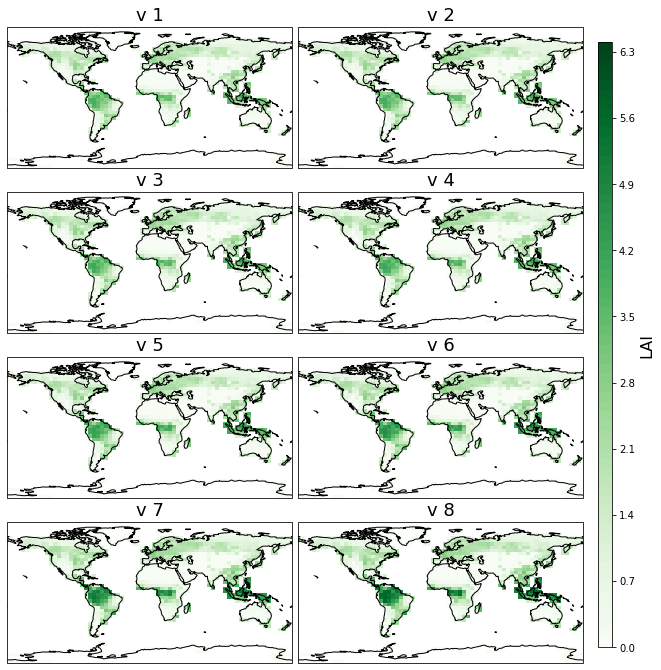

In [16]:
mus = []
clevs=np.arange(0,6.5,0.1)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    lai = fates_runs[i].FATES_LAI.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    cs= lai.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    # mean veg c in tropical forest grid cells
    trop_lai = lai.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    
    print(trop_lai.values)
    mus.append(trop_lai.values)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            
   
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI', fontsize=16)

In [17]:
incr = (mus[2] - mus[7])/mus[2] * 100
print(incr)

-37.12659478187561


#### Difference in LAI - all PFTs

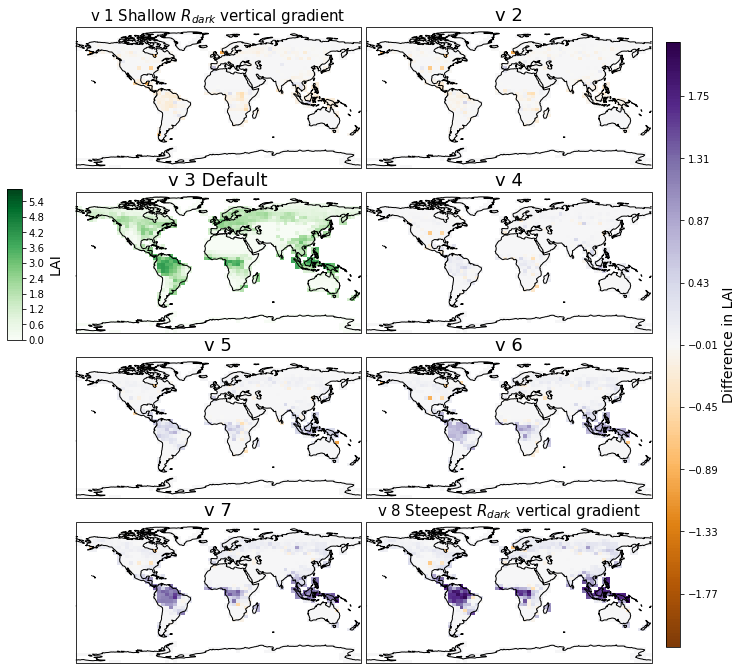

In [18]:
clevs=np.arange(-2.15,2.15,0.02)

clevs_def=np.arange(0,6,0.1)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

lai_def = fates_runs[2].FATES_LAI.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time')

axs = axs.flatten()
for i in range(0,nens):
    lai = fates_runs[i].FATES_LAI.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')
    lai_diff = lai - lai_def
    cs= lai_diff.plot(levels=clevs,cmap='PuOr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= lai_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference in LAI', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'LAI', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_LAI_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_LAI_diff.pdf', 
            bbox_inches='tight', facecolor='white')

####  Understory mortality - tree PFTs

inf
0.1920296
0.18708897
0.17929325
0.19265525
0.21994296
0.3741075
0.7071316


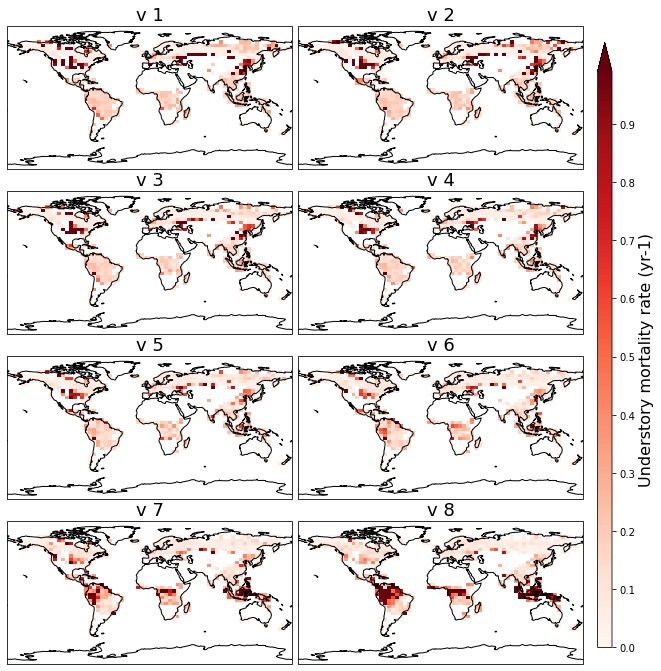

In [19]:
mus = []

clevs=np.arange(0,1,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
    mort_ustory_v1 = mort_ustory_v1.mean(dim=['time'], skipna=True)
    
    # mean veg c in tropical grid cells
    trop_mort = mort_ustory_v1.isel(lat=slice(-30,30)).mean(dim=['lat','lon'], skipna=True)
    print(trop_mort.values)
    mus.append(trop_mort.values)
    
    cs= mort_ustory_v1.plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory mortality rate (yr-1)', fontsize=16)

#### Difference in understory mortality - only tree PFTs

<xarray.DataArray ()>
array(inf, dtype=float32)
<xarray.DataArray ()>
array(0.00563994, dtype=float32)
<xarray.DataArray ()>
array(0., dtype=float32)
<xarray.DataArray ()>
array(-0.00568054, dtype=float32)
<xarray.DataArray ()>
array(0.00339035, dtype=float32)
<xarray.DataArray ()>
array(0.03211151, dtype=float32)
<xarray.DataArray ()>
array(0.19030704, dtype=float32)
<xarray.DataArray ()>
array(0.5283492, dtype=float32)


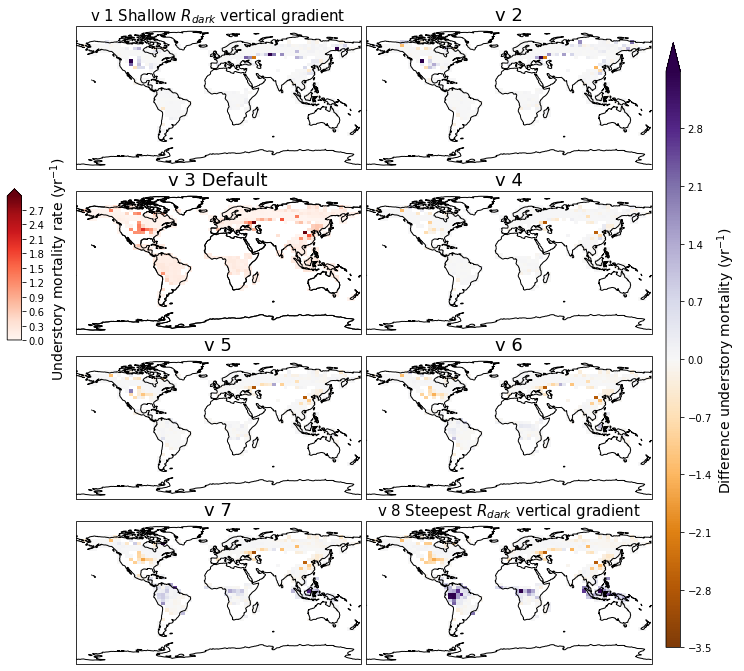

In [20]:
clevs=np.arange(-3.5,3.5,0.01)
clevs_def=np.arange(0,3.0,0.01)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_MORTALITY_USTORY_SZPF, fates_runs[2]).isel(fates_levpft=slice(0,6)) 
nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_NPLANT_USTORY_SZPF,  fates_runs[2]).isel(fates_levpft=slice(0,6))
mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
umort_def = mort_ustory_v1.mean(dim=['time'])

axs = axs.flatten()
for i in range(0,nens):
    mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
    umort = mort_ustory_v1.mean(dim=['time'])
    
    umort_diff = umort - umort_def
    
    trop = umort_diff.isel(lat=slice(-30,30))
    print(trop.mean(dim=['lat','lon']))
    
    cs= umort_diff.plot(levels=clevs,cmap='PuOr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= umort_def.plot(levels=clevs_def,cmap='Reds',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            


fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference understory mortality (yr$^{-1}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Understory mortality rate (yr$^{-1}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_mort_ustory_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_mort_ustory_diff.pdf', 
            bbox_inches='tight', facecolor='white')

### Carbon starvation mortality 

0.13442428
0.12764551
0.11961457
0.105161525
0.09115896
0.06654229
0.051528696
0.055350777


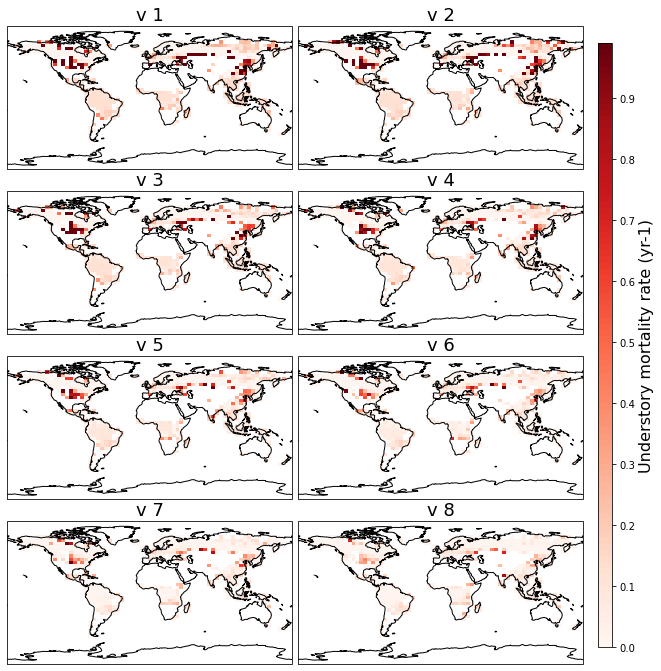

In [21]:
mus = []

clevs=np.arange(0,1,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_M3_MORTALITY_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
    mort_ustory_v1 = mort_ustory_v1.mean(dim=['time'], skipna=True)
    
    # mean veg c in tropical grid cells
    trop_mort = mort_ustory_v1.isel(lat=slice(-30,30)).mean(dim=['lat','lon'], skipna=True)
    print(trop_mort.values)
    mus.append(trop_mort.values)
    
    cs= mort_ustory_v1.plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory mortality rate (yr-1)', fontsize=16)

### Difference in carbon starvation mortality rates

<xarray.DataArray ()>
array(0.01653061, dtype=float32)
<xarray.DataArray ()>
array(0.00910411, dtype=float32)
<xarray.DataArray ()>
array(0., dtype=float32)
<xarray.DataArray ()>
array(-0.01380245, dtype=float32)
<xarray.DataArray ()>
array(-0.03125435, dtype=float32)
<xarray.DataArray ()>
array(-0.05491073, dtype=float32)
<xarray.DataArray ()>
array(-0.06874205, dtype=float32)
<xarray.DataArray ()>
array(-0.06900328, dtype=float32)


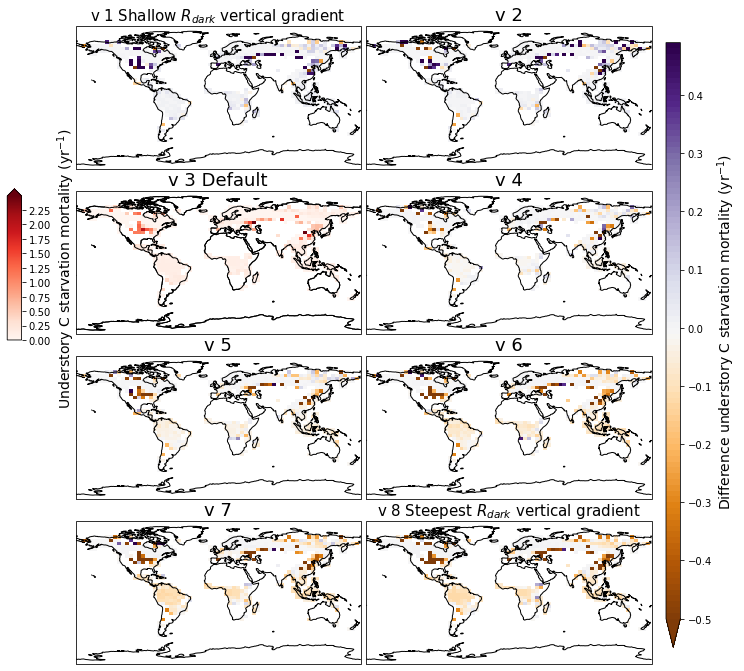

In [22]:
clevs=np.arange(-0.5,0.5,0.01)
clevs_def=np.arange(0,2.5,0.01)


fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_M3_MORTALITY_USTORY_SZPF, fates_runs[2]).isel(fates_levpft=slice(0,6)) 
nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_NPLANT_USTORY_SZPF,  fates_runs[2]).isel(fates_levpft=slice(0,6))
mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
umort_def = mort_ustory_v1.mean(dim=['time'])

axs = axs.flatten()
for i in range(0,nens):
    mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_M3_MORTALITY_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
    umort = mort_ustory_v1.mean(dim=['time'])
    
    umort_diff = umort - umort_def
    
    trop = umort_diff.isel(lat=slice(-30,30))
    print(trop.mean(dim=['lat','lon']))
    
    cs= umort_diff.plot(levels=clevs,cmap='PuOr', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= umort_def.plot(levels=clevs_def,cmap='Reds',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            


fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference understory C starvation mortality (yr$^{-1}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Understory C starvation mortality (yr$^{-1}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_cstarv_mort_ustory_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_cstarv_mort_ustory_diff.pdf', 
            bbox_inches='tight', facecolor='white')

#### Impact

inf
0.01800366
0.018686958
0.018990936
0.01988648
0.020307416
0.02058133
0.020958612


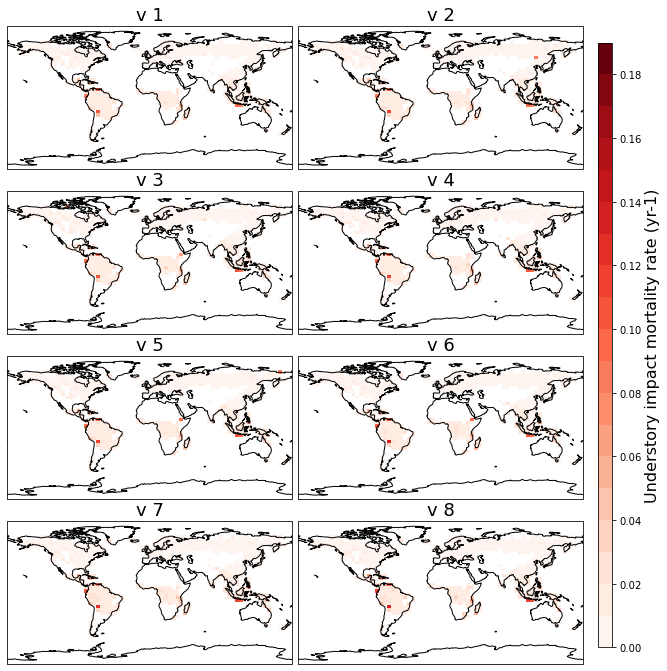

In [23]:
mus = []

clevs=np.arange(0,0.2,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    mort_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_MORTALITY_IMPACT_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    mort_ustory_v1 = mort_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    mort_ustory_v1 = mort_ustory_v1/nplant_ustory_v1
    mort_ustory_v1 = mort_ustory_v1.mean(dim=['time'], skipna=True)
    
    # mean veg c in tropical grid cells
    trop_mort = mort_ustory_v1.isel(lat=slice(-30,30)).mean(dim=['lat','lon'], skipna=True)
    print(trop_mort.values)
    mus.append(trop_mort.values)
    
    cs= mort_ustory_v1.plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory impact mortality rate (yr-1)', fontsize=16)

#### Total NPP - all PFTs

0.6750334338372149
0.6800807362682254
0.6948250720503222
0.708927167104403
0.7260047287549557
0.7470262630640383
0.7797938361319933
0.8104146836452685


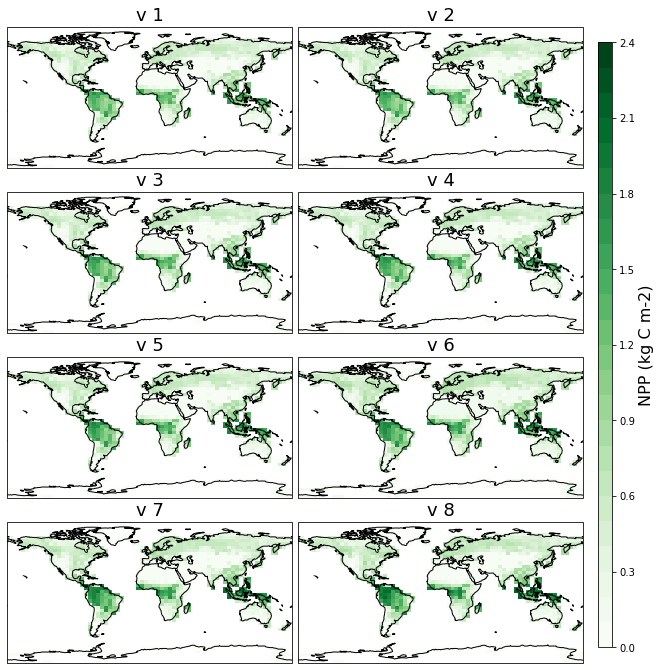

In [24]:
mus = []

clevs=np.arange(0,2.5,0.1)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    npp = fates_runs[i].FATES_NPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time') * 365 * 86400
    
    # mean veg c in tropical grid cells
    trop_npp = npp.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    print(trop_npp.values)
    mus.append(trop_npp.values)
    
    cs= npp.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('NPP (kg C m-2)', fontsize=16)

In [25]:
incr = (mus[2] - mus[5])/mus[2] * 100
print(incr)

-7.512853682679932


#### Change in NPP - all PFTs

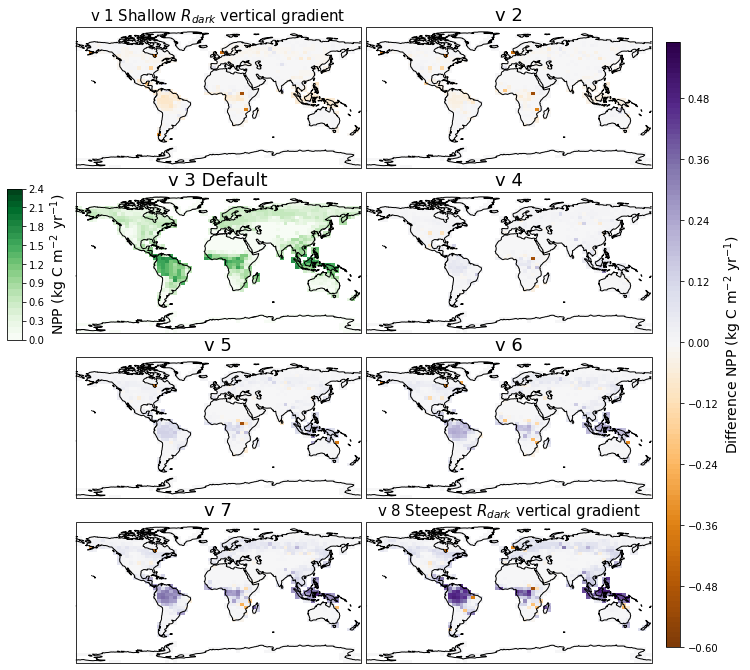

In [26]:
clevs=np.arange(-0.6,0.6,0.01)

clevs_def=np.arange(0,2.5,0.1)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 14))

npp_def = fates_runs[2].FATES_NPP.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time') * 86400 * 365


axs = axs.flatten()
for i in range(0,nens):
    npp = fates_runs[i].FATES_NPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')* 86400 * 365
    npp_diff = npp - npp_def
    cs= npp_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= npp_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            
 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference NPP (kg C m$^{-2}$ yr$^{-1}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'NPP (kg C m$^{-2}$ yr$^{-1}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_NPP_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_NPP_diff.pdf', 
            bbox_inches='tight', facecolor='white')

#### Total GPP - all PFTs

1.407609719897677
1.4100172478083646
1.4252212054299225
1.440845822647526
1.4549245351818099
1.4748093027834333
1.4986897294860988
1.500638455229337


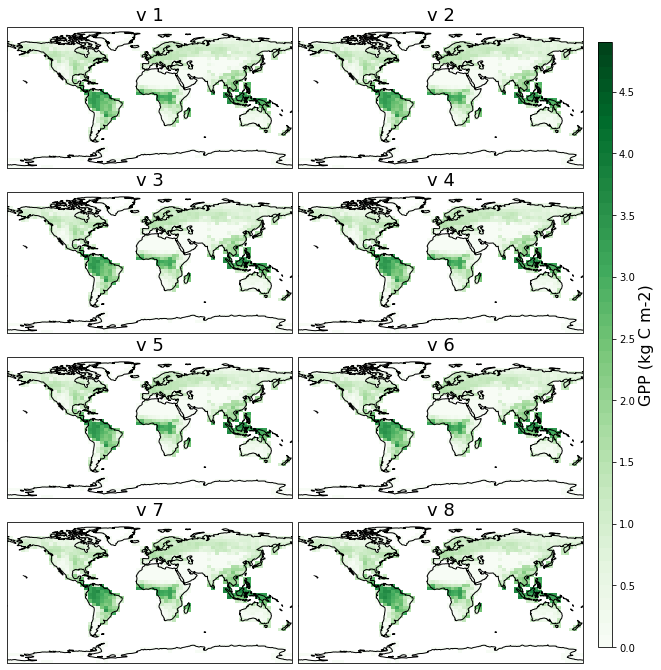

In [27]:
mus = []

clevs=np.arange(0,5.0,0.1)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    gpp = fates_runs[i].FATES_GPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time') * 365 * 86400
    
    # mean veg c in tropical grid cells
    trop_gpp = gpp.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    print(trop_gpp.values)
    mus.append(trop_gpp.values)
    
    cs= gpp.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('GPP (kg C m-2)', fontsize=16)

#### Change in GPP - all PFTs

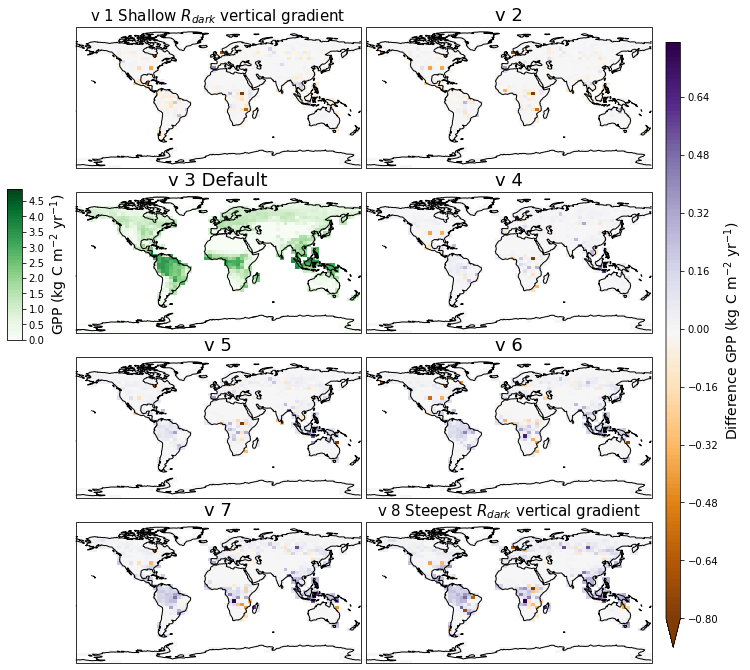

In [28]:
clevs=np.arange(-0.8,0.8,0.01)

clevs_def=np.arange(0,5.0,0.1)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 14))

gpp_def = fates_runs[2].FATES_GPP.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time') * 86400 * 365


axs = axs.flatten()
for i in range(0,nens):
    gpp = fates_runs[i].FATES_GPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')* 86400 * 365
    gpp_diff = gpp - gpp_def
    cs= gpp_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= gpp_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            
 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference GPP (kg C m$^{-2}$ yr$^{-1}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'GPP (kg C m$^{-2}$ yr$^{-1}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_GPP_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_GPP_diff.pdf', 
            bbox_inches='tight', facecolor='white')

### NPP/GPP - all PFTs

1.407609719897677
1.4100172478083646
1.4252212054299225
1.440845822647526
1.4549245351818099
1.4748093027834333
1.4986897294860988
1.500638455229337


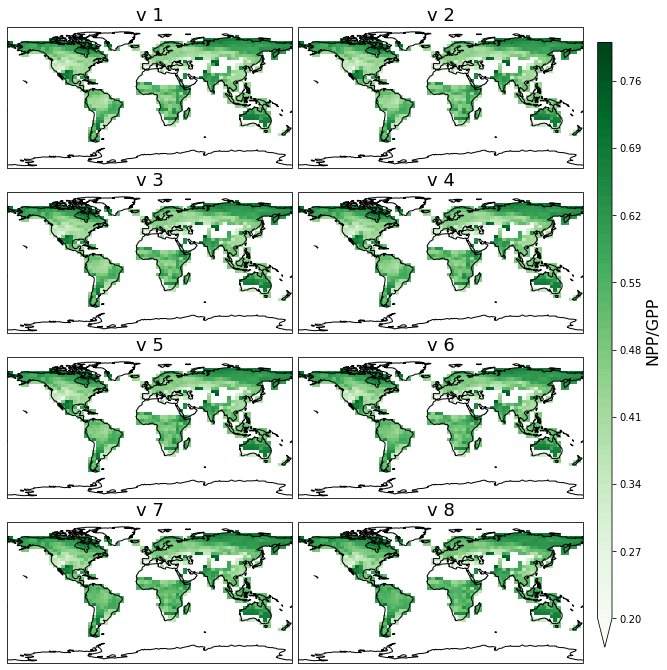

In [29]:
mus = []

clevs=np.arange(0.2,0.8,0.01)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):
    gpp = fates_runs[i].FATES_GPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time') * 365 * 86400
    npp = fates_runs[i].FATES_NPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time') * 365 * 86400
    cue = npp/gpp   

    # mean veg c in tropical grid cells
    trop_gpp = gpp.isel(lat=slice(-30,30)).mean(dim=['lat','lon'])
    print(trop_gpp.values)
    mus.append(trop_gpp.values)
    
    cs= cue.plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
            

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('NPP/GPP', fontsize=16)

#### Change in CUE - all PFTs

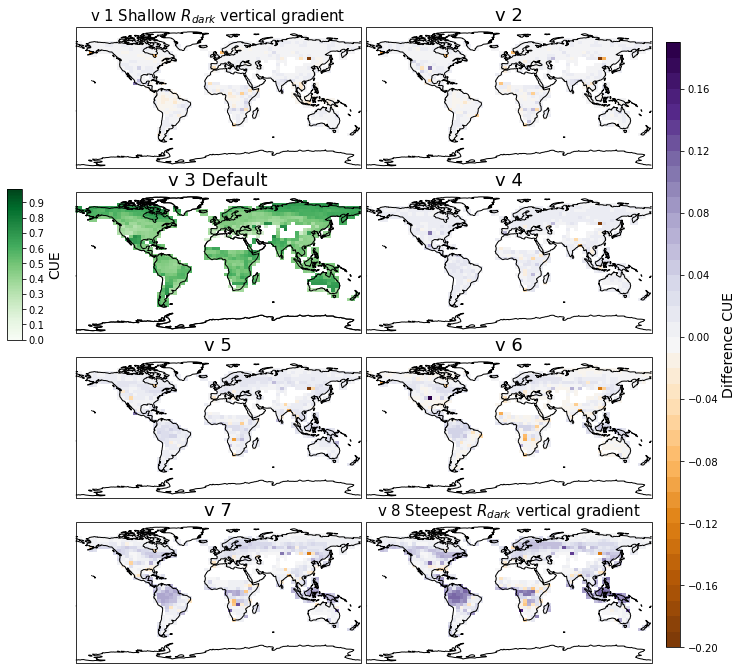

In [30]:
clevs=np.arange(-0.2,0.2,0.01)

clevs_def=np.arange(0,1.0,0.01)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 14))

gpp_def = fates_runs[2].FATES_GPP.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time') * 86400 * 365
npp_def = fates_runs[2].FATES_NPP.mean(dim='time') * fates_runs[2].FATES_FRACTION.mean(dim='time') * 86400 * 365
cue_def = npp_def/gpp_def

axs = axs.flatten()
for i in range(0,nens):
    gpp = fates_runs[i].FATES_GPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')* 86400 * 365
    npp = fates_runs[i].FATES_NPP.mean(dim='time') * fates_runs[i].FATES_FRACTION.mean(dim='time')* 86400 * 365
    cue = npp/gpp
    cue_diff = cue - cue_def
    cs= cue_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= cue_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            
 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference CUE', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'CUE', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_CUE_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_CUE_diff.pdf', 
            bbox_inches='tight', facecolor='white')

### Growth rates in the understory - tree PFTs

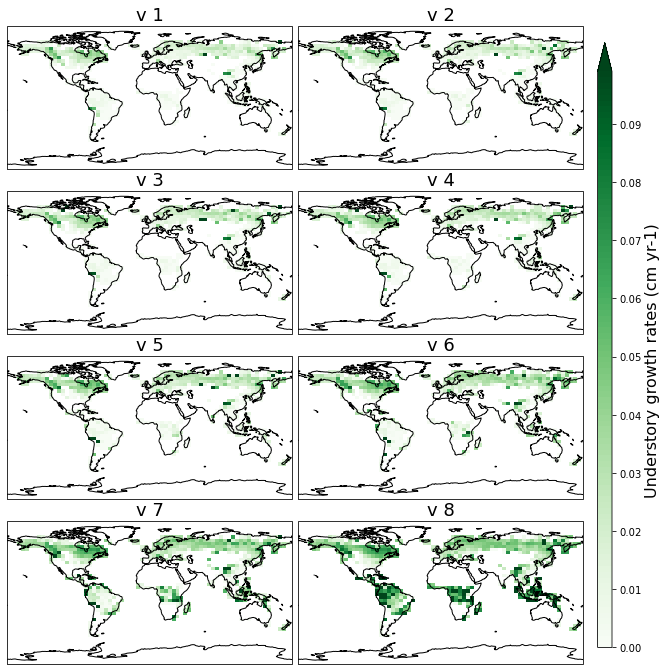

In [31]:
clevs=np.arange(0,0.1,0.001)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,14))

axs = axs.flatten()
for i in range(0,nens):

    ddbh_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_DDBH_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) * 100 
    nplant_ustory_v1 = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    ddbh_ustory_v1 = ddbh_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory_v1 = nplant_ustory_v1.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    ddbh_ustory_v1 = ddbh_ustory_v1/nplant_ustory_v1
    ddbh_ustory_v1 = ddbh_ustory_v1.mean(dim=['time'])
    cs= ddbh_ustory_v1.plot(levels=clevs,cmap='Greens',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
                 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Understory growth rates (cm yr-1)', fontsize=16)

#### Change in Understory growth rates 

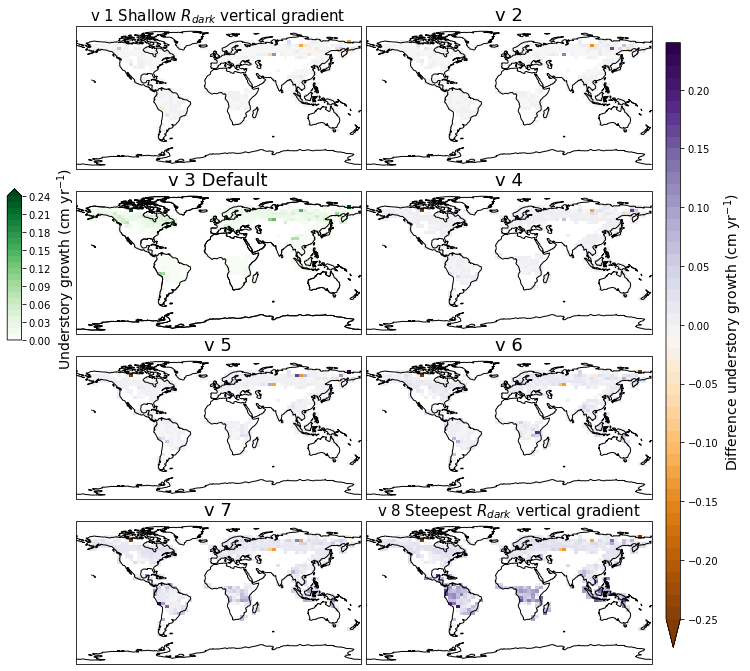

In [32]:
clevs=np.arange(-0.25,0.25,0.01)

clevs_def=np.arange(0.,0.25,0.01)

fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 14))

ddbh_ustory = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_DDBH_USTORY_SZPF, fates_runs[2]).isel(fates_levpft=slice(0,6)) * 100 
nplant_ustory = fa.scpf_to_scls_by_pft(fates_runs[2].FATES_NPLANT_USTORY_SZPF,  fates_runs[2]).isel(fates_levpft=slice(0,6))
ddbh_ustory = ddbh_ustory.sum(dim=['fates_levscls','fates_levpft'])
nplant_ustory = nplant_ustory.sum(dim=['fates_levscls','fates_levpft'])                                                                      
ddbh_ustory = ddbh_ustory/nplant_ustory
ddbh_ustory_def = ddbh_ustory.mean(dim=['time'])

axs = axs.flatten()
for i in range(0,nens):
    ddbh_ustory = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_DDBH_USTORY_SZPF, fates_runs[i]).isel(fates_levpft=slice(0,6)) * 100 
    nplant_ustory = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_NPLANT_USTORY_SZPF,  fates_runs[i]).isel(fates_levpft=slice(0,6))
    ddbh_ustory = ddbh_ustory.sum(dim=['fates_levscls','fates_levpft'])
    nplant_ustory = nplant_ustory.sum(dim=['fates_levscls','fates_levpft'])                                                                      
    ddbh_ustory = ddbh_ustory/nplant_ustory
    ddbh_ustory_new = ddbh_ustory.mean(dim=['time'])
    ddbh_ustory_diff = ddbh_ustory_new - ddbh_ustory_def 
    cs= ddbh_ustory_diff.plot(levels=clevs,cmap='PuOr',ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('v {0}'.format(i+1), fontsize=18)
    
    if i == 2: 
        ds= ddbh_ustory_def.plot(levels=clevs_def,cmap='Greens',ax=axs[i],add_colorbar=False)
        axs[i].coastlines()
        axs[i].set_title('v {0} Default'.format(i+1), fontsize=18)
    if i == 0: 
        axs[i].set_title('v 1 Shallow $R_{dark}$ vertical gradient', fontsize=15) 
    if i == (nens-1): 
        axs[i].set_title('v 8 Steepest $R_{dark}$ vertical gradient', fontsize=15)     
            
 
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)

cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Difference understory growth (cm yr$^{-1}$)', fontsize=14)

cbar_ax2 = fig.add_axes([0.005, 0.58, 0.02, 0.15])
cbar=fig.colorbar(ds, cax=cbar_ax2,orientation='vertical')
cbar.set_label(r'Understory growth (cm yr$^{-1}$)', fontsize=14)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_ddbh_ustory_diff.png', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Global_ddbh_ustory_diff.pdf', 
            bbox_inches='tight', facecolor='white')

## Compare to plot data

#### Load Piponiot and Galbraith data

In [33]:
df_pip = pd.read_csv('/global/homes/j/jneedham/plot_data/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')
df_pip.head(3)

site variable size_class   total  lower_bound  upper_bound
0  Amacayacu      AGB      [1,5)   4.667        4.577        4.756
1  Amacayacu      AGB     [5,10)  13.352       13.066       13.625
2  Amacayacu      AGB    [10,20)  40.574       39.664       41.437

In [34]:
df_pip_latlon = pd.read_csv('/global/homes/j/jneedham/plot_data/Piponiot_2022_totals.csv')
df_pip_latlon.head(3)

Site    Lat     Lon    AGB  AGB_l  AGB_u   AWP  AWP_l  AWP_u   AWM  AWM_l  \
0  Lenda  1.315   28.65  482.0  460.0  504.0  5.19   4.94   5.49  6.72   5.21   
1  Edoro  1.560   28.52  353.0  335.0  372.0  5.23   4.99   5.55  3.94   3.05   
2  Pasoh  2.980  102.31  321.0  309.0  334.0  8.27   8.04   8.53  9.58   8.46   

   AWM_u  
0   8.33  
1   4.93  
2  10.90

In [35]:
pip_lats = df_pip_latlon.Lat
pip_lons = df_pip_latlon.Lon
# convert to 0 to 360
def convert_longitude(lon):
    return (lon + 360) % 360

pip_lons  = [convert_longitude(lon) for  lon in pip_lons]
pip_names = df_pip_latlon.Site
n_plots = len(pip_lats)

In [36]:
df_gal = pd.read_csv('/global/homes/j/jneedham/plot_data/Galbraith_etal_2013_table_S1.csv')
new_colnames = ['Lat', 'Lon', 'AGB', 'AWP', 'Cres']
df_gal.columns = new_colnames
df_gal.head(3)

Lat   Lon    AGB   AWP   Cres
0  6.56 -2.22  307.0  3.32   92.4
1  6.48 -2.17  254.0  2.74  113.5
2  5.33 -4.17  510.0  5.08  100.5

In [37]:
gal_lats = df_gal.Lat
gal_lons = df_gal.Lon
# convert to 0 to 360
gal_lons  = [convert_longitude(lon) for  lon in gal_lons]

n_plots_gal = len(gal_lats)

### Size-dependent AGB, AWP and AWM

In [38]:
data_mids = [3, 7.5, 15, 25, 35, 45, 75, 150, 350]
data_widths = [4, 5, 10, 10, 10, 10, 50, 100, 300]
data_agb =  df_pip[df_pip['variable'] == 'AGB']
print(data_agb.head(3))

        site variable size_class   total  lower_bound  upper_bound
0  Amacayacu      AGB      [1,5)   4.667        4.577        4.756
1  Amacayacu      AGB     [5,10)  13.352       13.066       13.625
2  Amacayacu      AGB    [10,20)  40.574       39.664       41.437


In [39]:
cohort_size_bins_ex  = np.append(cohort_size_bins[1:],500)
fates_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
print(fates_mids)
fates_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[0:-1]
print(fates_widths)

[  3.    7.5  15.   25.   35.   45.   75.  150.  350. ]
[  4.   5.  10.  10.  10.  10.  50. 100. 300.]


#### AGB

In [40]:
agbs_v1 = []
agbs_v2 = []
agbs_v3 = []
agbs_v4 = []
agbs_v5 = []
agbs_v6 = []
agbs_v7 = []
agbs_v8 = []

for i in range(0,nens):
    fates_agb = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_VEGC_ABOVEGROUND_SZPF, fates_runs[i])  # untangle size and pft dimensions
    fates_agb = fates_agb.sum(dim='fates_levpft') # sum over pfts
    fates_agb = fates_agb.mean(dim='time') * 10  # mean over time and convert kg m-2 to Megagrams ha-1
    fates_agb = fates_agb.isel(fates_levscls=slice(1,None))
    # extract grid cells
    if i == 0 :
        for j in range(0,n_plots):
            agbs_v1.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 1 :
        for j in range(0,n_plots):
            agbs_v2.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 2 :
        for j in range(0,n_plots):
            agbs_v3.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 3 :
        for j in range(0,n_plots):
            agbs_v4.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 4 :
        for j in range(0,n_plots):
            agbs_v5.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 5 :
        for j in range(0,n_plots):
            agbs_v6.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 6 :
        for j in range(0,n_plots):
            agbs_v7.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 7 :
        for j in range(0,n_plots):
            agbs_v8.append(fates_agb.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))




Text(0.5, 0.01, 'DBH (cm)')

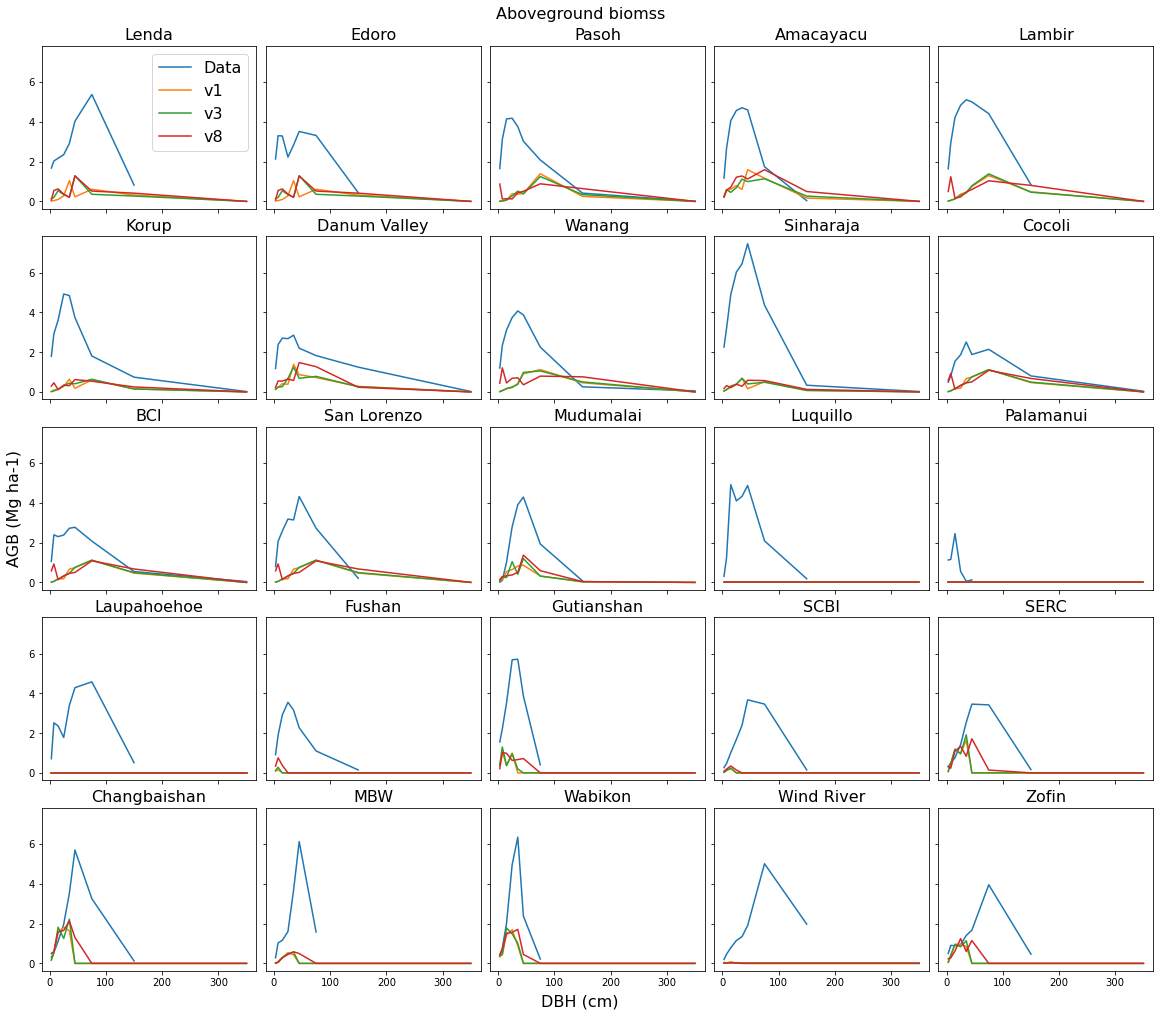

In [41]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(16,14),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_agb = data_agb[data_agb['site'] == name].total
        plot_mids = data_mids[0:len(plot_agb)]
        plot_widths = data_widths[0:len(plot_agb)]
        
        axs[i].plot(plot_mids, plot_agb/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, agbs_v1[i]/fates_widths, label = 'v1')
        #axs[i].plot(fates_mids, agbs_v2[i]/fates_widths, label = 'v2')
        axs[i].plot(fates_mids, agbs_v3[i]/fates_widths, label = 'v3')
        #axs[i].plot(fates_mids, agbs_v4[i]/fates_widths, label = 'v4')
        #axs[i].plot(fates_mids, agbs_v5[i]/fates_widths, label = 'v5')
        #axs[i].plot(fates_mids, agbs_v6[i]/fates_widths, label = 'v6')
        #axs[i].plot(fates_mids, agbs_v7[i]/fates_widths, label = 'v7')
        axs[i].plot(fates_mids, agbs_v8[i]/fates_widths, label = 'v8')
        axs[i].set_title(name, fontsize=16)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground biomss', fontsize=16)
fig.supylabel('AGB (Mg ha-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)

### AWP

In [42]:
awps_v1 = []
awps_v2 = []
awps_v3 = []
awps_v4 = []
awps_v5 = []
awps_v6 = []

for i in range(0,nens):
    fates_awp = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_ABOVEGROUND_PROD_SZPF, fates_runs[i])  # untangle size and pft dimensions
    fates_awp = fates_awp.sum(dim='fates_levpft') # sum over pfts
    fates_awp = fates_awp.mean(dim='time')   # mean over time 
    fates_awp = fates_awp.isel(fates_levscls=slice(1,None)) * 10 * 365 * 86400
    # extract grid cells
    if i == 0 :
        for j in range(0,n_plots):
            awps_v1.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 1 :
        for j in range(0,n_plots):
            awps_v2.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 2 :
        for j in range(0,n_plots):
            awps_v3.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 3 :
        for j in range(0,n_plots):
            awps_v4.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 4 :
        for j in range(0,n_plots):
            awps_v5.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 5 :
        for j in range(0,n_plots):
            awps_v6.append(fates_awp.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))


In [43]:
data_awp =  df_pip[df_pip['variable'] == 'AWP']

Text(0.5, 0.01, 'DBH (cm)')

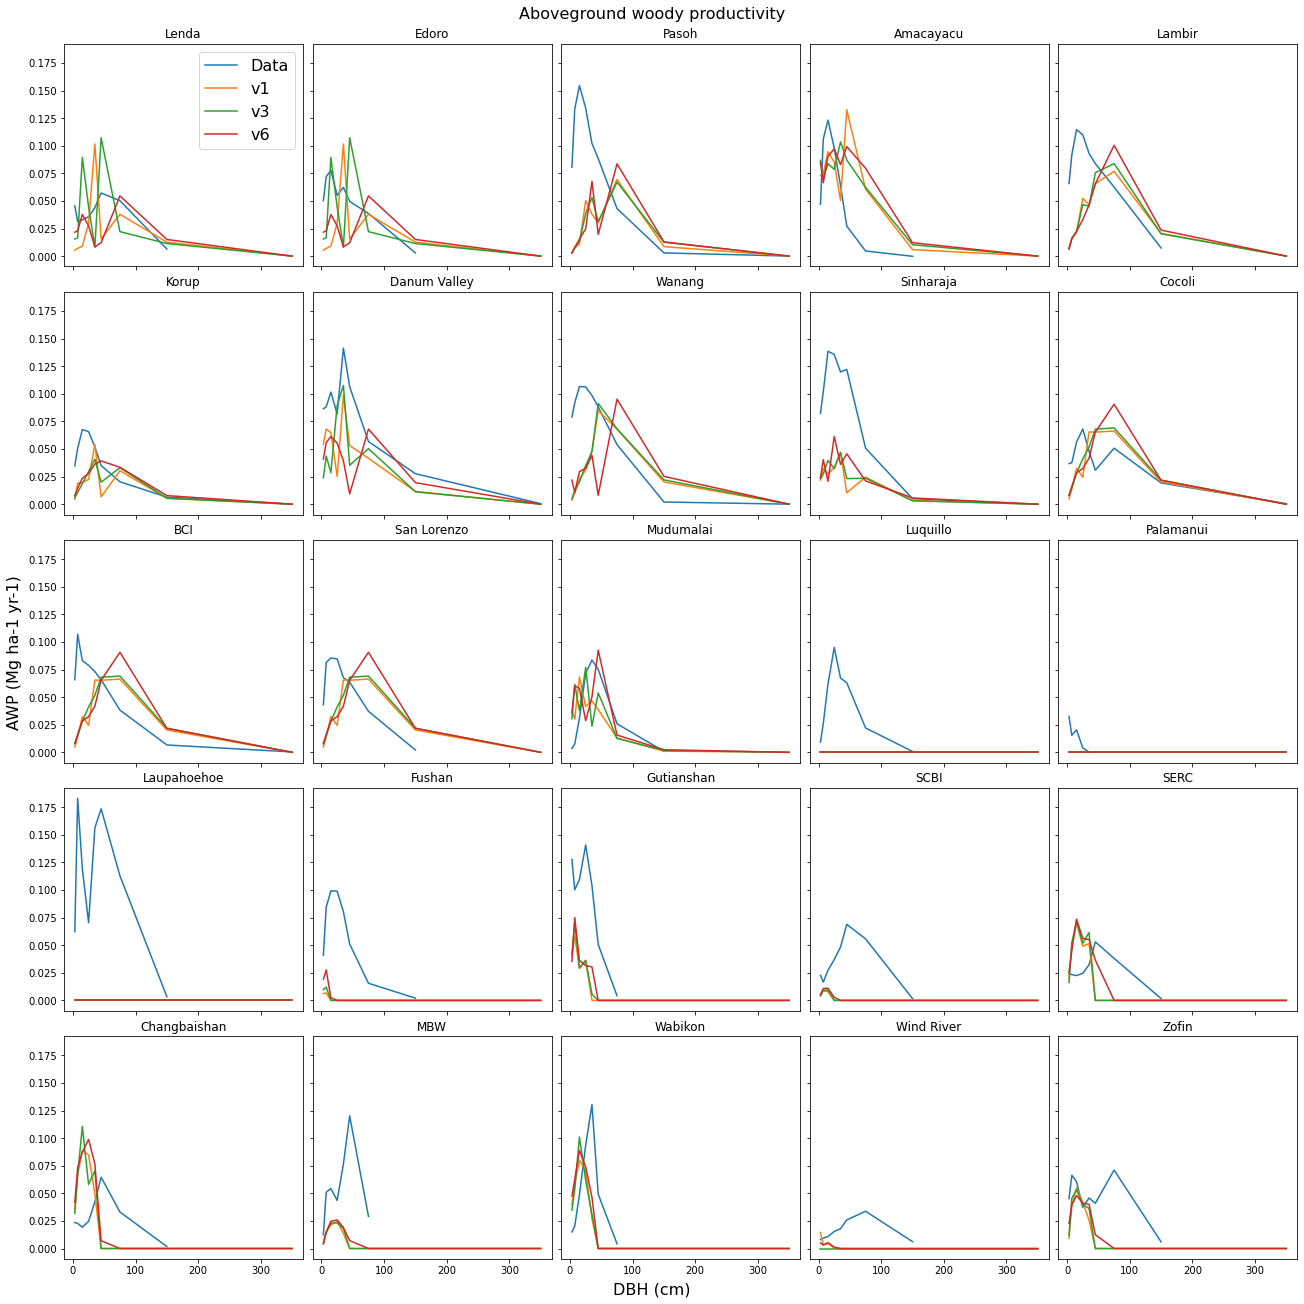

In [44]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(18,18),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_awp = data_awp[data_awp['site'] == name].total
        plot_mids = data_mids[0:len(plot_awp)]
        plot_widths = data_widths[0:len(plot_awp)]
        
        axs[i].plot(plot_mids, plot_awp/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, awps_v1[i]/fates_widths, label = 'v1')
        axs[i].plot(fates_mids, awps_v3[i]/fates_widths, label = 'v3')
        axs[i].plot(fates_mids, awps_v6[i]/fates_widths, label = 'v6')
        axs[i].set_title(name)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground woody productivity', fontsize=16)
fig.supylabel('AWP (Mg ha-1 yr-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)

#### AWM

In [45]:
awms_v1 = []
awms_v2 = []
awms_v3 = []
awms_v4 = []
awms_v5 = []
awms_v6 = []

for i in range(0,nens):
    fates_awm = fa.scpf_to_scls_by_pft(fates_runs[i].FATES_ABOVEGROUND_MORT_SZPF, fates_runs[i])  # untangle size and pft dimensions
    fates_awm = fates_awm.sum(dim='fates_levpft') # sum over pfts
    fates_awm = fates_awm.mean(dim='time')   # mean over time 
    fates_awm = fates_awm.isel(fates_levscls=slice(1,None)) * 10 * 365 * 86400
    # extract grid cells
    if i == 0 :
        for j in range(0,n_plots):
            awms_v1.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 1 :
        for j in range(0,n_plots):
            awms_v2.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 2 :
        for j in range(0,n_plots):
            awms_v3.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 3 :
        for j in range(0,n_plots):
            awms_v4.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 4 :
        for j in range(0,n_plots):
            awms_v5.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))
    if i == 5 :
        for j in range(0,n_plots):
            awms_v6.append(fates_awm.sel(lat=pip_lats[j], lon=pip_lons[j], method='nearest'))


In [46]:
data_awm =  df_pip[df_pip['variable'] == 'AWM']

''

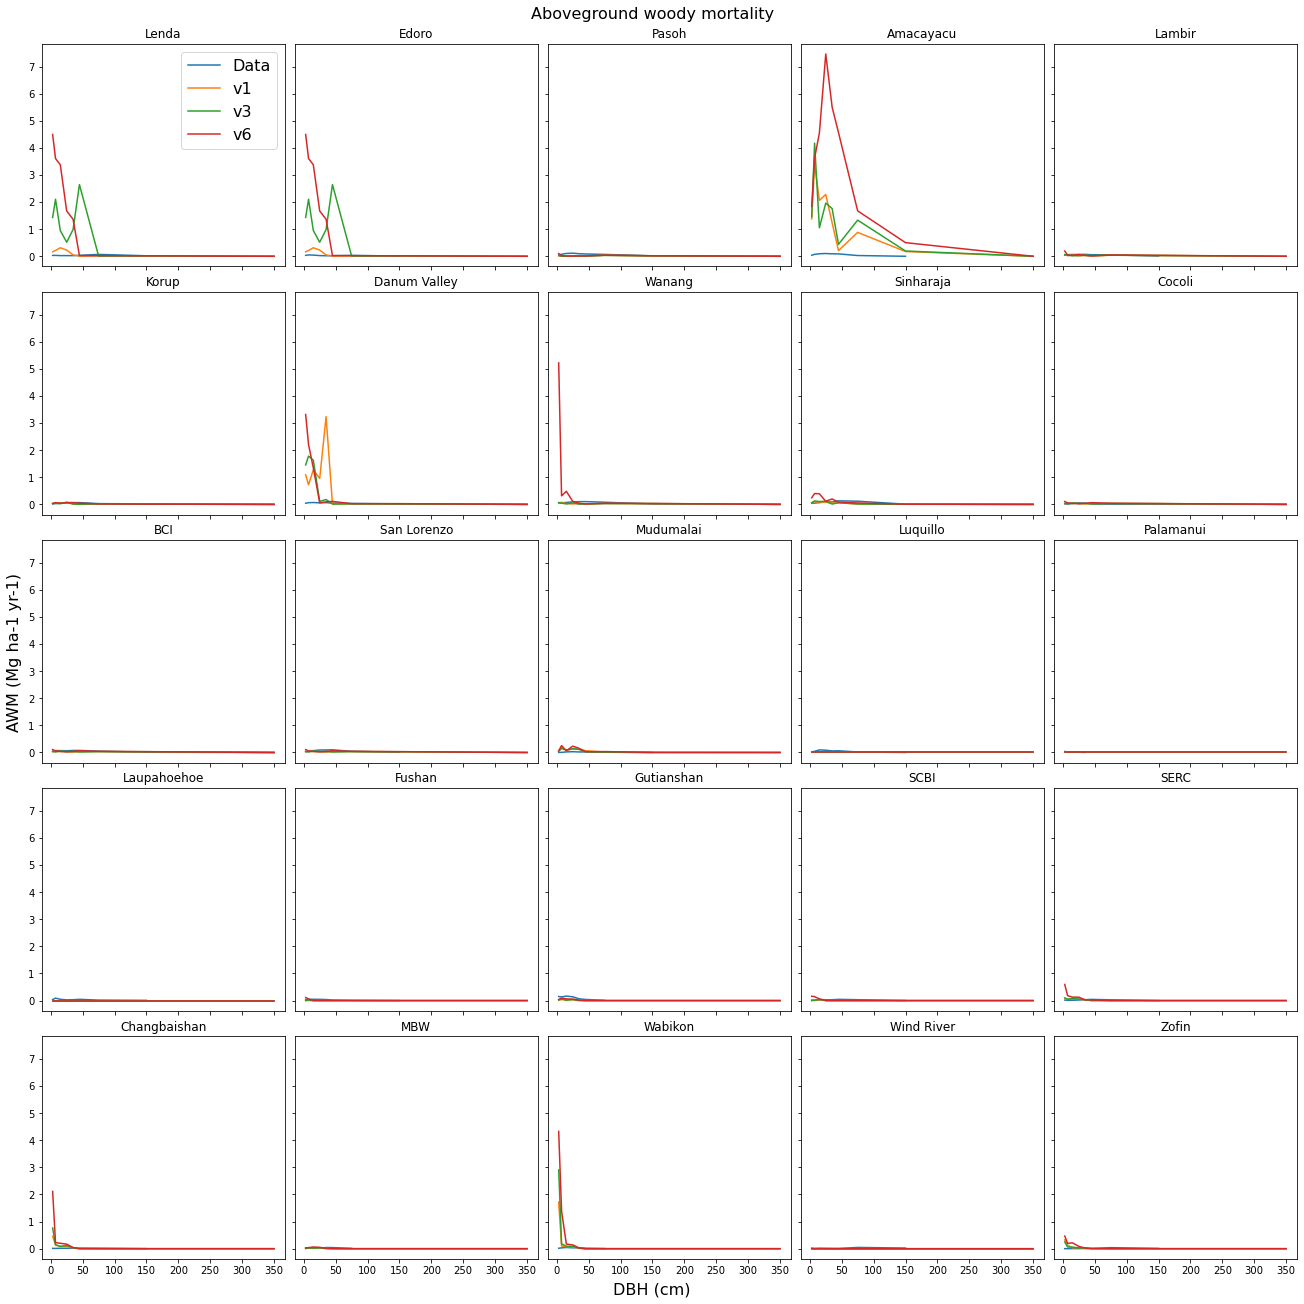

In [47]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(18,18),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_awm = data_awm[data_awm['site'] == name].total
        plot_mids = data_mids[0:len(plot_awm)]
        plot_widths = data_widths[0:len(plot_awm)]
        
        axs[i].plot(plot_mids, plot_awm/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, awms_v1[i]/fates_widths, label = 'v1')
        axs[i].plot(fates_mids, awms_v3[i]/fates_widths, label = 'v3')
        axs[i].plot(fates_mids, awms_v6[i]/fates_widths, label = 'v6')
        axs[i].set_title(name)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground woody mortality', fontsize=16)
fig.supylabel('AWM (Mg ha-1 yr-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)
;